In [3]:
import numpy as np
import boto3
import io
import os
import PIL
import tensorflow as tf

In [4]:
def open_s3_image(bucket_name, key):
    client = boto3.client('s3')
    full_object = client.get_object(Bucket=bucket_name, Key=key)
    return PIL.Image.open(io.BytesIO(full_object['Body'].read()))

In [5]:
def open_s3_bucket(bucket_name, limit=1000):
    #Returns a list of PIL images from the images in a python bucket
    resource = boto3.resource('s3')
#     client = boto3.client('s3')
    bucket = resource.Bucket(bucket_name)
    images = []
    for idx, obj in enumerate(bucket.objects.all()):
        images.append(open_s3_image(bucket_name, obj.key))
        if idx >= limit:
            break
    return images
#         full_object = client.get_object(Bucket=bucket_name, Key=obj.key)
#         images.append(PIL.Image.open(io.BytesIO(full_object['Body'].read())))

In [6]:
def open_s3_key_list(bucket_name, keys):
    images = []
    for key in keys:
        images.append(open_s3_image(bucket_name, key))
    return images

In [7]:
def compute_crop_box(bucket_name, left_sizing_key, top_sizing_key, right_sizing_key, bottom_sizing_key,
                    original_width, original_height):
    keys = [left_sizing_key, top_sizing_key, right_sizing_key, bottom_sizing_key]
    sizing_images = open_s3_key_list(bucket_name, keys)
    left_pixel = original_width - sizing_images[0].width
    top_pixel = original_height - sizing_images[1].height
    right_pixel = sizing_images[2].width
    bottom_pixel = sizing_images[3].height
    return [left_pixel, top_pixel, right_pixel, bottom_pixel]

In [8]:
# compute YuGiOh cropbox
def compute_yugioh_crop_box():
    bucket_name = 'sizing-images'
    left = 'Left.jpg'
    top = 'Top.jpg'
    right = 'Right.jpg'
    bottom = 'Bottom.jpg'
    card_images = open_s3_bucket('yugiohcardimages', 1)
    width, height = card_images[0].size
    return compute_crop_box(bucket_name, left, top, right, bottom, width, height)

In [30]:
def compute_magic_crop_box():
    bucket_name = 'sizing-images'
    folder = 'magic'
    left = folder + '/Left.jpg'
    top = folder + '/Top.jpg'
    right = folder + '/Right.jpg'
    bottom = folder + '/Bottom.jpg'
    card_images = open_s3_bucket('magic-cards2', 1)
    width, height = card_images[0].size
    return compute_crop_box(bucket_name, left, top, right, bottom, width, height)

In [45]:
def get_cropped_images(bucket_name, crop_box):
    return map(lambda img: img.crop(crop_box), open_s3_bucket(bucket_name))

In [53]:
def get_yugioh_images():
    return get_cropped_images('yugiohcardimages', compute_YuGiOh_crop_box())

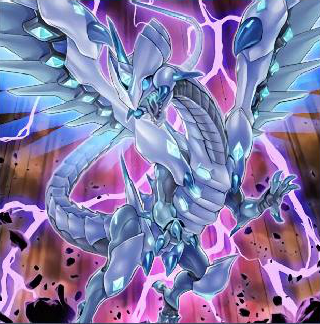

In [54]:
def get_magic_images():
    magic_images = get_cropped_images('magic-cards2', compute_magic_crop_box())
    return map(lambda img: img.resize((320, 324)), magic_images)

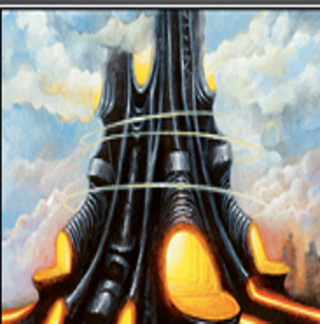

In [59]:
def get_random_images():
    return map(lambda img: img.resize((320, 324)), open_s3_bucket('random-images2'))